#### Task 1: 
- Team: (20 points)
    - Develop Linear and Non-Linear (polynomial with degree n) regression models for predicting cases and deaths in US. 
        - Start your data from 2020.06.01 (Monday) to 2021.01.03 (Sunday) of infections in US.
            X-Axis - number of days, Y-Axis - number of new cases and deaths. (5 points)
        - Calculate and report Root Mean Square Error (RMSE) for your models (linear and non-linear). https://en.wikipedia.org/wiki/Root-mean-square_deviation. Discuss bias versus variance tradeoff. (5 points)
        - Plot trend line along for the data along with the forecast of 1 week ahead (i.e. make prediction on 2021.01.04 - 2021.01.10). (5 points)
        - Describe the trends as compared to other countries. (5 points)

In [26]:
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
cases = pd.read_csv("covid_confirmed_usafacts.csv")
deaths = pd.read_csv("covid_deaths_usafacts.csv")

In [3]:
def get_dates(data): #function from stage 2
    dates = data.loc[:, [i not in ["countyFIPS","County Name", "State", "StateFIPS"] for i in data]] #Extract non dates
    
    dates.columns = pd.to_datetime(dates.columns) #Fix columns to be date times
    
    dates = dates.loc[:, [(i >= datetime.datetime(2020, 5, 25)) and (i <= datetime.datetime(2021, 1, 3)) for i in dates]] #Extract correct time
    return dates #make dates start 1 week earlier for get_weekly() purposes
def get_weekly(dates): #tweaked function from stage 2

    weeks = [range(i, i + 7) for i in range(0, len(dates.columns), 7)]
    dates.iloc[:, weeks[0]]
    
    stats = pd.DataFrame({"week": [],"sum" : []})
    
    for i in range(len(weeks)-1):
        date = dates.iloc[:, weeks[i+1]].iloc[0, :].keys()[0]
        #Subtract numbers from previous week to get new case/death data (current data is cumulative)
        week = (dates.iloc[:, weeks[i+1]].sum(axis = 1)) - (dates.iloc[:, weeks[i]].sum(axis = 1))
        wsum = week.sum()/7/7
        new_row = pd.DataFrame({"week": date,"sum" : (wsum)}, index=[i])
        stats = pd.concat([stats, new_row])
    return stats

In [4]:
cases_dates = get_dates(cases)
cases_weeks = get_weekly(cases_dates)
cX = cases_weeks["week"]
deaths_dates = get_dates(deaths)
deaths_weeks = get_weekly(deaths_dates)
dX = deaths_weeks["week"]
cy = cases_weeks["sum"]
dy = deaths_weeks["sum"]

In [5]:
cX_train, cX_test, cy_train, cy_test = train_test_split(cX, cy, test_size = 0.3, random_state = 42)
dX_train, dX_test, dy_train, dy_test = train_test_split(dX, dy, test_size = 0.3, random_state = 42)

In [6]:
cases_weeks


,week,sum
0,2020-06-01,22149.122449
1,2020-06-08,21728.734694
2,2020-06-15,25697.510204
3,2020-06-22,35613.612245
4,2020-06-29,47301.346939
5,2020-07-06,55634.632653
6,2020-07-13,65254.673469
7,2020-07-20,65544.387755
8,2020-07-27,61563.612245
9,2020-08-03,54727.693878


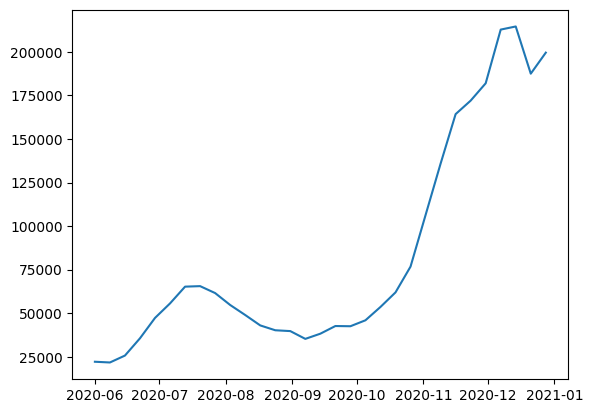

In [7]:
plt.plot(cases_weeks["week"], cases_weeks["sum"])

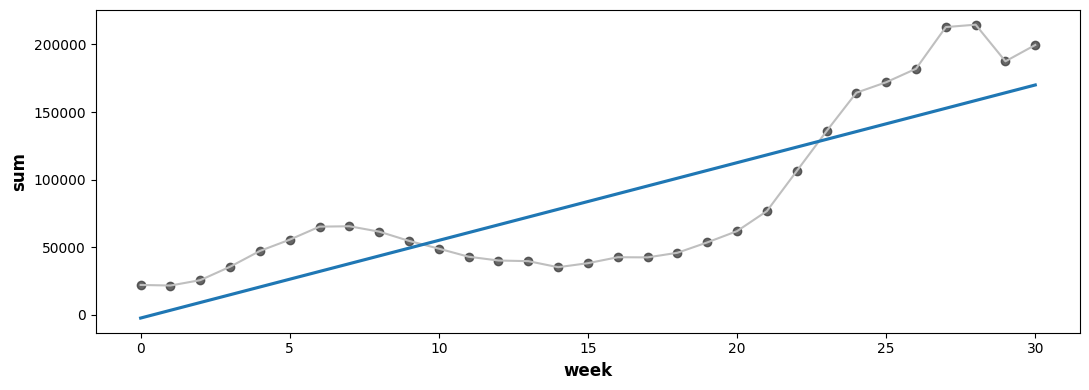

In [11]:
# Linear regression tutorial: https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series
cases_weeks['week'] = np.arange(len(cases_weeks['week']))
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
fig, ax = plt.subplots()
ax.plot("week", "sum", data=cases_weeks, color='0.75')
ax = sns.regplot(x='week', y='sum', data=cases_weeks, ci=None, scatter_kws=dict(color='0.25'))

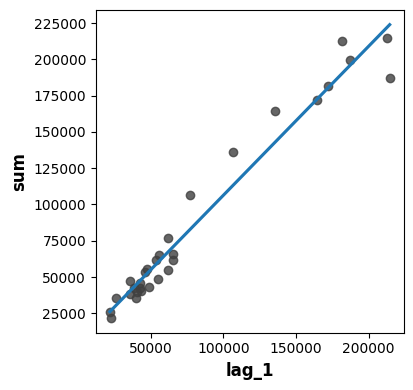

In [14]:
cases_weeks["lag_1"] = cases_weeks["sum"].shift(1)
fig, ax = plt.subplots()
ax = sns.regplot(x='lag_1', y='sum', data=cases_weeks, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')

In [15]:
from sklearn.linear_model import LinearRegression
X = cases_weeks.loc[:, ['lag_1']]
X.dropna(inplace=True)
y = cases_weeks.loc[:, 'sum']
y, X = y.align(X, join='inner')
model = LinearRegression()
model.fit(X,y)
y_pred = pd.Series(model.predict(X),index=X.index)

Text(0.5, 0, 'Lag_1')

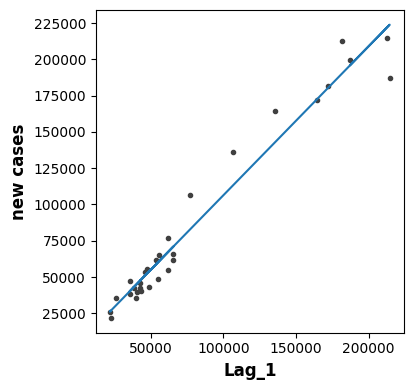

In [16]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set_aspect('equal')
ax.set_ylabel('new cases')
ax.set_xlabel('Lag_1')

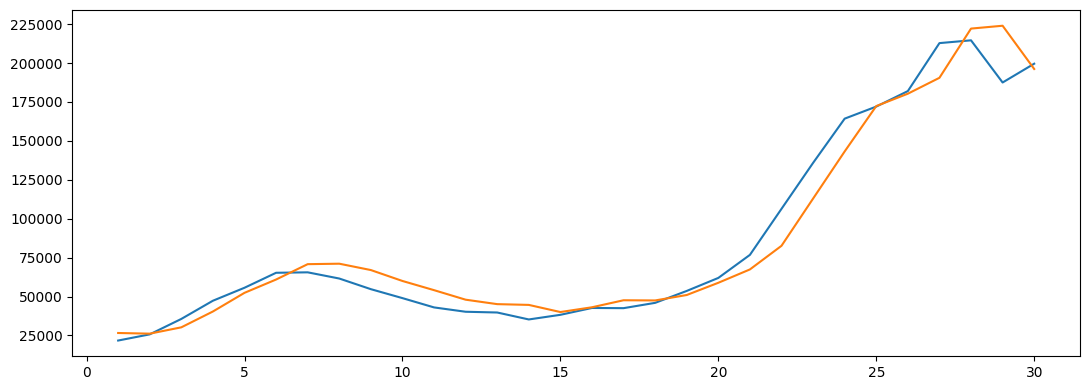

In [33]:
ax = y.plot()
ax = y_pred.plot()

In [31]:
MSE = mean_squared_error(y,y_pred)
print("Linear reg RMSE: ", np.sqrt(MSE))

Linear reg RMSE:  12091.283601241648


In [ ]:
# Non-Linear regression tutorial: https://pieriantraining.com/nonlinear-regression-in-machine-learning-python/